# &#x1F4D1; &nbsp;  Build  a  Digit Recognition Models

## Links
[SciPy. Multi-dimensional image processing](https://docs.scipy.org/doc/scipy/reference/ndimage.html)

[Keras. Deep Learning library for Theano and TensorFlow](https://keras.io/)
 
[TensorFlow. Deep MNIST for Experts](https://www.tensorflow.org/get_started/mnist/pros)

[Tensorflow Deep MNIST Advanced Tutorial](http://docs.seldon.io/tensorflow-deep-mnist-example.html)

[Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras](http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)

## Libraries

In [1]:
%%html
<style>        
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #818286; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;} 
</style>

In [44]:
import numpy as np
import scipy as sp
import pandas as pd
from time import time

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML, display

import matplotlib.pylab as plt
import matplotlib.cm as cm

import cv2

%matplotlib inline

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model, neighbors, svm, ensemble
from sklearn import datasets, metrics 
from sklearn.model_selection import train_test_split

In [51]:
import keras as ks
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers import AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.embeddings import Embedding
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.vgg16 import VGG16 
from keras.applications.vgg19 import VGG19

## Dataset

In [5]:
df_train = pd.read_csv("kaggle_digits_train.csv")
df_test = pd.read_csv("kaggle_digits_test.csv")
df_train.shape

(42000, 785)

In [6]:
df_train.ix[15:20,15:20]

,pixel14,pixel15,pixel16,pixel17,pixel18
15,0,0,0,0,0
16,0,0,0,0,0
17,0,0,0,0,0
18,0,0,0,0,0
19,0,0,0,0,0
20,0,0,0,0,0


In [7]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
train_images = np.array(df_train[images])
train_images = train_images.astype('float32')/255
train_images.shape

(42000, 784)

In [8]:
train_labels = df_train['label']
train_labels_cat = ks.utils.to_categorical(train_labels, num_classes=10)
train_labels_cat.shape

(42000, 10)

In [9]:
test_images = np.array(df_test[images])
test_images = test_images.astype('float32')/255
test_images.shape

(28000, 784)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_cat, 
                                                    test_size=0.2, random_state=32)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33600, 784), (8400, 784), (33600, 10), (8400, 10))

In [12]:
y_train_num = np.array([np.argmax(x) for x in y_train])
y_test_num = np.array([np.argmax(x) for x in y_test])

In [46]:
X_train_app = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in X_train]
X_train_app = np.concatenate([arr[np.newaxis] for arr in X_train_app]).astype('float32')

X_test_app = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in X_test]
X_test_app = np.concatenate([arr[np.newaxis] for arr in X_test_app]).astype('float32')

In [47]:
X_train_app.shape, X_test_app.shape, y_train.shape, y_test.shape

((33600, 32, 32, 3), (8400, 32, 32, 3), (33600, 10), (8400, 10))

## Examples

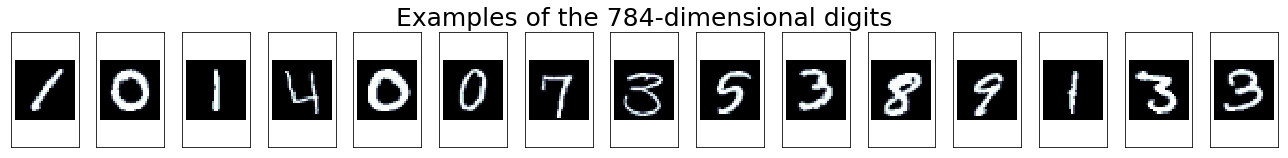

In [13]:
fig, ax = plt.subplots(figsize=(18, 2), nrows=1, ncols=15, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(15):
    image = train_images[i].reshape(28,28)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[7].set_title('Examples of the 784-dimensional digits', fontsize=25);

In [14]:
X_train_tensor = tf.image.grayscale_to_rgb(X_train.reshape(-1, 28, 28, 1), name=None)
X_test_tensor = tf.image.grayscale_to_rgb(X_test.reshape(-1, 28, 28, 1), name=None)

In [15]:
sess = tf.Session()
with sess.as_default():
    X_train_color = X_train_tensor.eval()
    X_test_color = X_test_tensor.eval()

In [16]:
X_train_color.shape, X_test_color.shape

((33600, 28, 28, 3), (8400, 28, 28, 3))

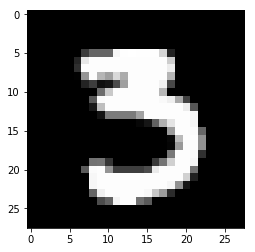

In [17]:
plt.imshow(X_test_color[0]);

## Neural Network Models

### Model #1. Convolutional Neural Network. Keras

In [20]:
def cnn_mc_model():
    model_input = Input(shape=(28, 28, 1))
    x = BatchNormalization()(model_input)
    
    x = Conv2D(28, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(96, (5, 5), activation='relu')(x)
    x = MaxPooling2D(strides=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = GlobalMaxPooling2D()(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    y = Dense(10, activation='softmax')(x)
    
    model = Model(input=model_input, output=y)
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cnn_mc_model = cnn_mc_model()

In [21]:
cnn_checkpointer = ModelCheckpoint(filepath='weights.best3.cnn_mc.digits.hdf5', 
                                   verbose=2, save_best_only=True)

fit_cnn = cnn_mc_model.fit(X_train.reshape(-1, 28, 28, 1), y_train, 
                           validation_data=(X_test.reshape(-1, 28, 28, 1), y_test), 
                           epochs=100, batch_size=128, verbose=2, callbacks=[cnn_checkpointer])

Train on 33600 samples, validate on 8400 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.14132, saving model to weights.best3.cnn_mc.digits.hdf5
97s - loss: 0.5652 - acc: 0.8125 - val_loss: 0.1413 - val_acc: 0.9698
Epoch 2/100
Epoch 00001: val_loss improved from 0.14132 to 0.07016, saving model to weights.best3.cnn_mc.digits.hdf5
106s - loss: 0.1544 - acc: 0.9535 - val_loss: 0.0702 - val_acc: 0.9787
Epoch 3/100
Epoch 00002: val_loss improved from 0.07016 to 0.05581, saving model to weights.best3.cnn_mc.digits.hdf5
112s - loss: 0.1156 - acc: 0.9637 - val_loss: 0.0558 - val_acc: 0.9850
Epoch 4/100
Epoch 00003: val_loss improved from 0.05581 to 0.04738, saving model to weights.best3.cnn_mc.digits.hdf5
106s - loss: 0.0969 - acc: 0.9707 - val_loss: 0.0474 - val_acc: 0.9864
Epoch 5/100
Epoch 00004: val_loss improved from 0.04738 to 0.04180, saving model to weights.best3.cnn_mc.digits.hdf5
104s - loss: 0.0817 - acc: 0.9756 - val_loss: 0.0418 - val_acc: 0.9871
Epoch 6/100
Epoc

Epoch 00061: val_loss did not improve
94s - loss: 0.0194 - acc: 0.9942 - val_loss: 0.0270 - val_acc: 0.9937
Epoch 63/100
Epoch 00062: val_loss did not improve
93s - loss: 0.0184 - acc: 0.9941 - val_loss: 0.0309 - val_acc: 0.9927
Epoch 64/100
Epoch 00063: val_loss did not improve
93s - loss: 0.0220 - acc: 0.9929 - val_loss: 0.0287 - val_acc: 0.9920
Epoch 65/100
Epoch 00064: val_loss did not improve
94s - loss: 0.0216 - acc: 0.9937 - val_loss: 0.0256 - val_acc: 0.9932
Epoch 66/100
Epoch 00065: val_loss did not improve
93s - loss: 0.0194 - acc: 0.9940 - val_loss: 0.0262 - val_acc: 0.9931
Epoch 67/100
Epoch 00066: val_loss did not improve
93s - loss: 0.0210 - acc: 0.9937 - val_loss: 0.0318 - val_acc: 0.9923
Epoch 68/100
Epoch 00067: val_loss did not improve
99s - loss: 0.0210 - acc: 0.9941 - val_loss: 0.0282 - val_acc: 0.9923
Epoch 69/100
Epoch 00068: val_loss did not improve
116s - loss: 0.0187 - acc: 0.9940 - val_loss: 0.0324 - val_acc: 0.9918
Epoch 70/100
Epoch 00069: val_loss did not i

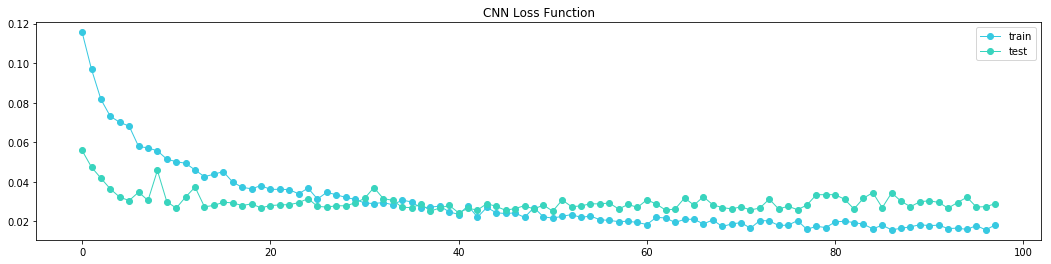

In [22]:
plt.figure(figsize=(18, 4))
plt.plot(fit_cnn.history['loss'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_cnn.history['val_loss'][2:], '-o', c='#39d4be', lw=1, label = 'test')
plt.legend()
plt.title('CNN Loss Function');

In [23]:
cnn_mc_model.load_weights('weights.best3.cnn_mc.digits.hdf5')
cnn_scores = cnn_mc_model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test, verbose=0)

print("CNN Scores: " , (cnn_scores))
print("CNN Error: %.2f%%" % (100 - cnn_scores[1]*100))
print(cnn_mc_model.summary())

CNN Scores:  [0.024262220928410117, 0.99321428571428572]
CNN Error: 0.68%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 28)        728       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 96)        67296     
_________________________________________________________________
ma

In [24]:
steps, epochs = 1000, 70
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

fit_dg_cnn = cnn_mc_model.fit_generator(data_generator.flow(X_train.reshape(-1, 28, 28, 1), 
                                                            y_train, 
                                                            batch_size=128),
                                        steps_per_epoch = steps, epochs = epochs,
                                        validation_data = (X_test.reshape(-1, 28, 28, 1), y_test), 
                                        callbacks=[cnn_checkpointer], verbose=2)

Epoch 1/70
Epoch 00000: val_loss did not improve
361s - loss: 0.1244 - acc: 0.9633 - val_loss: 0.0261 - val_acc: 0.9925
Epoch 2/70
Epoch 00001: val_loss improved from 0.02426 to 0.02287, saving model to weights.best3.cnn_mc.digits.hdf5
350s - loss: 0.0983 - acc: 0.9708 - val_loss: 0.0229 - val_acc: 0.9931
Epoch 3/70
Epoch 00002: val_loss did not improve
359s - loss: 0.0881 - acc: 0.9739 - val_loss: 0.0229 - val_acc: 0.9933
Epoch 4/70
Epoch 00003: val_loss did not improve
374s - loss: 0.0866 - acc: 0.9743 - val_loss: 0.0231 - val_acc: 0.9945
Epoch 5/70
Epoch 00004: val_loss did not improve
371s - loss: 0.0811 - acc: 0.9764 - val_loss: 0.0241 - val_acc: 0.9933
Epoch 6/70
Epoch 00005: val_loss improved from 0.02287 to 0.02045, saving model to weights.best3.cnn_mc.digits.hdf5
369s - loss: 0.0795 - acc: 0.9764 - val_loss: 0.0204 - val_acc: 0.9945
Epoch 7/70
Epoch 00006: val_loss did not improve
373s - loss: 0.0751 - acc: 0.9781 - val_loss: 0.0212 - val_acc: 0.9942
Epoch 8/70
Epoch 00007: va

Epoch 00063: val_loss did not improve
324s - loss: 0.0561 - acc: 0.9832 - val_loss: 0.0173 - val_acc: 0.9955
Epoch 65/70
Epoch 00064: val_loss did not improve
323s - loss: 0.0557 - acc: 0.9837 - val_loss: 0.0178 - val_acc: 0.9950
Epoch 66/70
Epoch 00065: val_loss did not improve
324s - loss: 0.0559 - acc: 0.9834 - val_loss: 0.0198 - val_acc: 0.9949
Epoch 67/70
Epoch 00066: val_loss did not improve
324s - loss: 0.0564 - acc: 0.9830 - val_loss: 0.0182 - val_acc: 0.9955
Epoch 68/70
Epoch 00067: val_loss did not improve
323s - loss: 0.0563 - acc: 0.9835 - val_loss: 0.0185 - val_acc: 0.9954
Epoch 69/70
Epoch 00068: val_loss did not improve
324s - loss: 0.0519 - acc: 0.9844 - val_loss: 0.0198 - val_acc: 0.9946
Epoch 70/70
Epoch 00069: val_loss did not improve
323s - loss: 0.0563 - acc: 0.9832 - val_loss: 0.0180 - val_acc: 0.9957


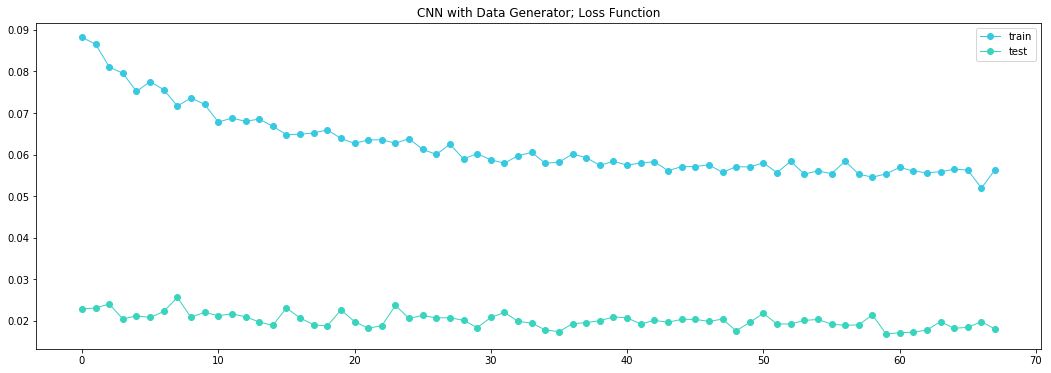

In [25]:
plt.figure(figsize=(18, 6))
plt.plot(fit_dg_cnn.history['loss'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_dg_cnn.history['val_loss'][2:], '-o', c='#39d4be', lw=1, label = 'test')
plt.legend()
plt.title('CNN with Data Generator; Loss Function');

In [26]:
cnn_mc_model.load_weights('weights.best3.cnn_mc.digits.hdf5')
cnn_scores = cnn_mc_model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test, verbose=0)

print("CNN with Data Generator; Scores: " , (cnn_scores))
print("CNN with Data Generator; Error: %.2f%%" % (100 - cnn_scores[1]*100))

CNN with Data Generator; Scores:  [0.016856584487359213, 0.99595238095238092]
CNN with Data Generator; Error: 0.40%


In [27]:
cnn_mc_model.save('kaggle_digits_cnn_mc_model3.h5')

### Model #2. Multi-layer Perceptron. Keras

In [75]:
def mlp_mc_model():
    model = Sequential()

    model.add(Dense(1568, activation='relu', input_shape = X_train.shape[1:]))
    model.add(Dropout(0.2))
    
    model.add(Dense(392, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mlp_mc_model = mlp_mc_model()

In [91]:
mlp_checkpointer = ModelCheckpoint(filepath='weights.best.mlp_mc.digits.hdf5', 
                                   verbose=2, save_best_only=True)
fit_mlp = mlp_mc_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                           epochs=15, batch_size=128, verbose=2, callbacks=[mlp_checkpointer]);

Train on 33600 samples, validate on 8400 samples
Epoch 1/15
Epoch 00000: val_loss improved from inf to 0.15568, saving model to weights.best.mlp_mc.digits.hdf5
24s - loss: 0.3195 - acc: 0.9008 - val_loss: 0.1557 - val_acc: 0.9507
Epoch 2/15
Epoch 00001: val_loss improved from 0.15568 to 0.10542, saving model to weights.best.mlp_mc.digits.hdf5
20s - loss: 0.1274 - acc: 0.9606 - val_loss: 0.1054 - val_acc: 0.9681
Epoch 3/15
Epoch 00002: val_loss improved from 0.10542 to 0.10227, saving model to weights.best.mlp_mc.digits.hdf5
20s - loss: 0.0924 - acc: 0.9730 - val_loss: 0.1023 - val_acc: 0.9705
Epoch 4/15
Epoch 00003: val_loss did not improve
19s - loss: 0.0740 - acc: 0.9772 - val_loss: 0.1023 - val_acc: 0.9717
Epoch 5/15
Epoch 00004: val_loss did not improve
19s - loss: 0.0626 - acc: 0.9813 - val_loss: 0.1158 - val_acc: 0.9710
Epoch 6/15
Epoch 00005: val_loss did not improve
19s - loss: 0.0575 - acc: 0.9826 - val_loss: 0.1029 - val_acc: 0.9744
Epoch 7/15
Epoch 00006: val_loss improved f

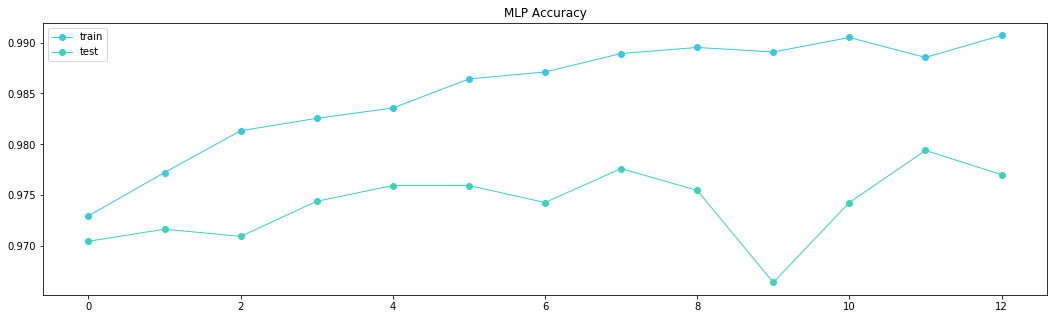

In [185]:
plt.figure(figsize=(18,5))
plt.plot(fit_mlp.history['acc'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_mlp.history['val_acc'][2:], '-o', c='#39d4be', lw=1, label = 'test')
plt.legend()
plt.title('MLP Accuracy');

In [96]:
mlp_mc_model.load_weights('weights.best.mlp_mc.digits.hdf5')
mlp_scores = mlp_mc_model.evaluate(X_test, y_test)

print("\nMLP Scores: ", (mlp_scores))
print("MLP Error: %.2f%%" % (100 - mlp_scores[1] * 100))
print(mlp_mc_model.summary())

8400/8400 [==============================] - 2s     

In [97]:
mlp_mc_model.save('kaggle_digits_mlp_mc_model.h5')

### Model #3. Recurrent Neural Network. Keras

In [70]:
def rnn_mc_model():
    model = Sequential()

    model.add(LSTM(196, return_sequences=True, input_shape=(1, 784)))    
    model.add(LSTM(196, return_sequences=True))
    
    model.add(LSTM(784))  
    
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])    
    return model 

In [71]:
rnn_mc_model = rnn_mc_model()
rnn_checkpointer = ModelCheckpoint(filepath='weights.best.rnn_mc.digits.hdf5', 
                                   verbose=2, save_best_only=True)
fit_rnn = rnn_mc_model.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1]), y_train, 
                           epochs=10, batch_size=128, verbose=2, callbacks=[rnn_checkpointer],
                           validation_data=(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test))

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 0.17883, saving model to weights.best.rnn_mc.digits.hdf5
93s - loss: 0.3666 - acc: 0.8876 - val_loss: 0.1788 - val_acc: 0.9444
Epoch 2/10
Epoch 00001: val_loss improved from 0.17883 to 0.12626, saving model to weights.best.rnn_mc.digits.hdf5
83s - loss: 0.1207 - acc: 0.9620 - val_loss: 0.1263 - val_acc: 0.9618
Epoch 3/10
Epoch 00002: val_loss improved from 0.12626 to 0.12022, saving model to weights.best.rnn_mc.digits.hdf5
82s - loss: 0.0774 - acc: 0.9752 - val_loss: 0.1202 - val_acc: 0.9629
Epoch 4/10
Epoch 00003: val_loss improved from 0.12022 to 0.10942, saving model to weights.best.rnn_mc.digits.hdf5
82s - loss: 0.0538 - acc: 0.9825 - val_loss: 0.1094 - val_acc: 0.9664
Epoch 5/10
Epoch 00004: val_loss improved from 0.10942 to 0.08593, saving model to weights.best.rnn_mc.digits.hdf5
84s - loss: 0.0419 - acc: 0.9867 - val_loss: 0.0859 - val_acc: 0.9757
Epoch 6/10
Epoch 00005: val_lo

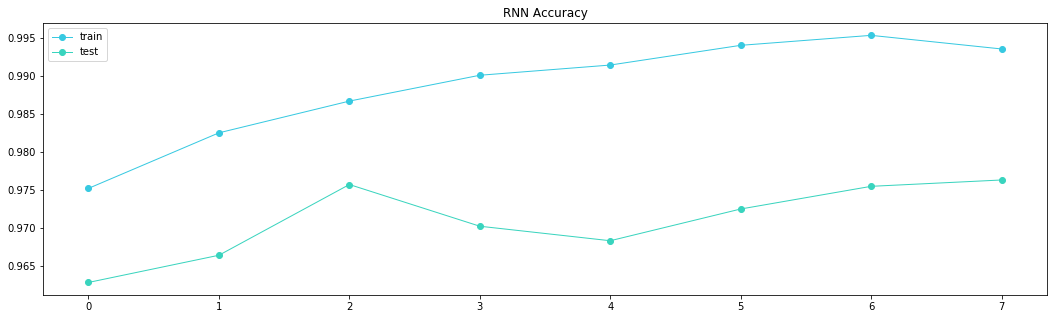

In [173]:
plt.figure(figsize=(18,5))
plt.plot(fit_rnn.history['acc'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_rnn.history['val_acc'][2:], '-o', c='#39d4be', lw=1, label = 'test')
plt.legend()
plt.title('RNN Accuracy');

In [73]:
rnn_mc_model.load_weights('weights.best.rnn_mc.digits.hdf5')
rnn_scores = rnn_mc_model.evaluate(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test)

print("\nRNN Scores: ", (rnn_scores))
print("RNN Error: %.2f%%" % (100 - rnn_scores[1] * 100))
print(rnn_mc_model.summary())

8384/8400 [============================>.] - ETA: 0s

In [74]:
rnn_mc_model.save('kaggle_digits_rnn_mc_model.h5')

### Model #4. MLPClassifier. Scikit-Learn

In [91]:
clf = MLPClassifier(hidden_layer_sizes=(784,), max_iter=50, alpha=1e-4,
                     solver='adam', verbose=1, tol=1e-6, random_state=1,
                     learning_rate_init=7e-4, batch_size=128)
clf.fit(X_train, y_train);

Iteration 1, loss = 0.94378841
Iteration 2, loss = 0.40011765
Iteration 3, loss = 0.28336239
Iteration 4, loss = 0.21722986
Iteration 5, loss = 0.17410363
Iteration 6, loss = 0.14131103
Iteration 7, loss = 0.11730296
Iteration 8, loss = 0.09752419
Iteration 9, loss = 0.08076081
Iteration 10, loss = 0.06640700
Iteration 11, loss = 0.05535066
Iteration 12, loss = 0.04585736
Iteration 13, loss = 0.03845437
Iteration 14, loss = 0.03147112
Iteration 15, loss = 0.02565168
Iteration 16, loss = 0.02093476
Iteration 17, loss = 0.01767376
Iteration 18, loss = 0.01517816
Iteration 19, loss = 0.01263184
Iteration 20, loss = 0.01070031
Iteration 21, loss = 0.00873292
Iteration 22, loss = 0.00763798
Iteration 23, loss = 0.00644964
Iteration 24, loss = 0.00566928
Iteration 25, loss = 0.00514124
Iteration 26, loss = 0.00476469
Iteration 27, loss = 0.00401193
Iteration 28, loss = 0.00387241
Iteration 29, loss = 0.02353646
Iteration 30, loss = 0.00877345
Iteration 31, loss = 0.00362994
Iteration 32, los

In [92]:
print("MNIST. MLPClassifier. Train score: %f" % (clf.score(X_train, y_train)*100),'%')
print("MNIST. MLPClassifier. Test score: %f" % (clf.score(X_test, y_test)*100),'%')

MNIST. MLPClassifier. Train score: 100.000000 %
MNIST. MLPClassifier. Test score: 96.380952 %


In [93]:
clf2 = MLPClassifier(hidden_layer_sizes=(784,), max_iter=50, alpha=1e-4,
                     solver='lbfgs', verbose=1, tol=1e-6, random_state=1,
                     learning_rate_init=7e-4, batch_size=128)
clf2.fit(X_train, y_train_num);

In [94]:
print("MNIST. MLPClassifier. Train score: %f" % (clf2.score(X_train, y_train_num)*100),'%')
print("MNIST. MLPClassifier. Test score: %f" % (clf2.score(X_test, y_test_num)*100),'%')

MNIST. MLPClassifier. Train score: 98.092262 %
MNIST. MLPClassifier. Test score: 96.916667 %


## Classifiers

In [175]:
classifier_list = []
classifier_names = []
clf_datasets = []

acc_train, acc_test = [], []
loss_train, loss_test = [], []

In [176]:
def classifier_fit_score(classifier, classifier_name, clf_dataset, x_train, x_test, y_train, y_test):
    classifier_list.append(str(classifier))
    classifier_names.append(str(classifier_name))
    clf_datasets.append(str(clf_dataset))
    
    clf = classifier
    clf.fit(x_train, y_train)
    
    y_clf_train = clf.predict(x_train)
    y_clf_test = clf.predict(x_test)
        
    acc_clf_train = round(metrics.accuracy_score(y_train, y_clf_train), 4)
    acc_train.append(acc_clf_train)
    acc_clf_test = round(metrics.accuracy_score(y_test, y_clf_test), 4)
    acc_test.append(acc_clf_test)
    
    loss_clf_train = round(metrics.hamming_loss(y_train, y_clf_train), 4)
    loss_train.append(loss_clf_train)
    loss_clf_test = round(metrics.hamming_loss(y_test, y_clf_test), 4)
    loss_test.append(loss_clf_test)
    
    return [y_clf_train, y_clf_test, acc_clf_train, acc_clf_test, loss_clf_train, loss_clf_test]

In [177]:
def get_classifier_results():
    df_results = pd.DataFrame({'classifier' : classifier_list,
                               'classifier_name': classifier_names,
                               'clf_dataset': clf_datasets,
                               'acc_train': acc_train, 
                               'acc_test': acc_test,
                               'loss_train': loss_train, 
                               'loss_test': loss_test})
    
    df_list = ['classifier_name', 'acc_train', 'acc_test', 'loss_train', 'loss_test']
               
    return df_results, df_results[df_list]

In [178]:
clf1 = neighbors.KNeighborsClassifier()
clf2 = linear_model.LogisticRegressionCV() 
clf3 = ensemble.GradientBoostingClassifier()

In [179]:
y_knc_train, y_knc_test = classifier_fit_score(clf1, 'KNeighborsClassifier', 'digits',
                                               X_train, X_test, y_train_num, y_test_num)[:2]

In [180]:
y_lrcvc_train, y_lrcvc_test = classifier_fit_score(clf2, 'LogisticRegressionCV', 'digits',
                                                   X_train, X_test, y_train_num, y_test_num)[:2]

In [181]:
y_gbc_train, y_gbc_test = classifier_fit_score(clf3, 'GradientBoostingClassifier', 'digits',
                                               X_train, X_test, y_train_num, y_test_num)[:2]

In [182]:
df_results, df_results2  = get_classifier_results()
df_results2.sort_values('acc_test', ascending=False)

,classifier_name,acc_train,acc_test,loss_train,loss_test
0,KNeighborsClassifier,0.9778,0.9657,0.0222,0.0343
2,GradientBoostingClassifier,0.9676,0.9440,0.0324,0.0560
1,LogisticRegressionCV,0.9282,0.9177,0.0718,0.0823


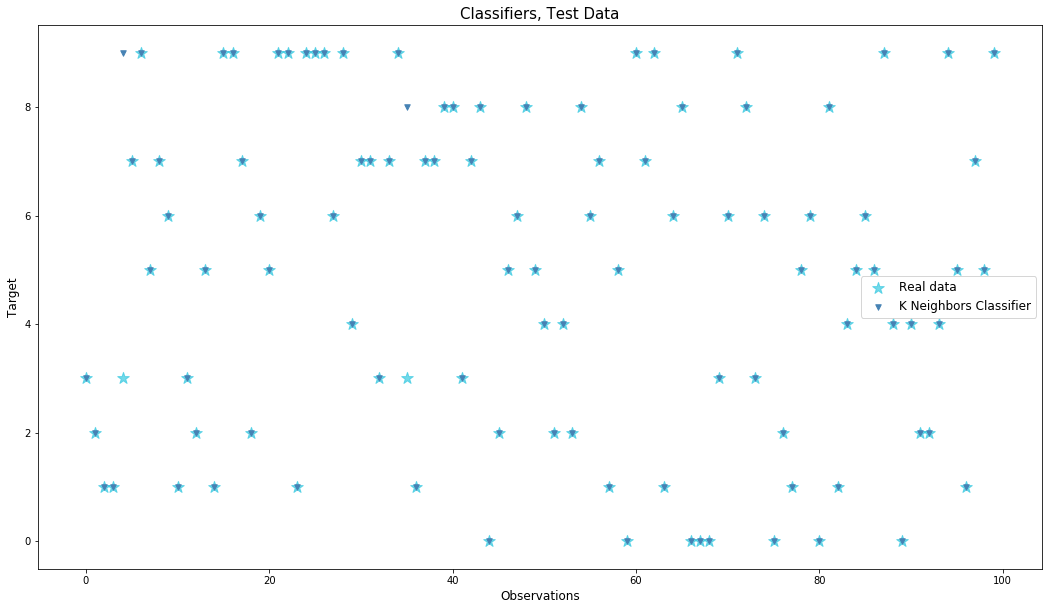

In [208]:
plt.figure(figsize=(18, 10))
n=100
x=range(n)

plt.scatter(x, y_test_num[:n], marker='*', s=150, color='#37c9e1', alpha=0.7, label='Real data')

plt.scatter(x, y_knc_test[:n], marker='v', s=30, color='steelblue', label='K Neighbors Classifier')
# plt.scatter(x, y_lrcvc_test[:n], marker='s', s=30, color='darkblue', label='Logistic RegressionCV')
# plt.scatter(x, y_gbc_test[:n], marker='o', s=30, color='darkgreen', label='GradientBoostingClassifier')

plt.xlabel('Observations', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title('Classifiers, Test Data', fontsize=15)
plt.legend(loc=5, fontsize=12);

## Applications

In [52]:
vgg16_base_model = VGG16(weights='imagenet', include_top=False)
X_train_bn = vgg16_base_model.predict(X_train_app)
X_test_bn = vgg16_base_model.predict(X_test_app)

In [57]:
X_train_bn.shape

(33600, 1, 1, 512)

In [54]:
np.save('X_train_bn.npy', X_train_bn.reshape(X_train_bn.shape[0], X_train_bn.shape[3]))
np.save('X_test_bn.npy', X_test_bn.reshape(X_test_bn.shape[0], X_test_bn.shape[3]))

In [56]:
X_train_bn = np.load('X_train_bn.npy')
X_test_bn = np.load('X_test_bn.npy')
X_train_bn = X_train_bn.reshape(X_train_bn.shape[0], 1, 1, X_train_bn.shape[1])
X_test_bn = X_test_bn.reshape(X_test_bn.shape[0], 1, 1, X_test_bn.shape[1])

In [79]:
def vgg16_add_model():
    model = Sequential()
    model.add(GlobalMaxPooling2D(input_shape=X_train_bn.shape[1:]))

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [80]:
vgg16_add_model = vgg16_add_model()
vgg16_checkpointer = ModelCheckpoint(filepath='weights.best.vgg16.digits.hdf5', 
                                     verbose=2, save_best_only=True)

In [81]:
vgg16_add_history = vgg16_add_model.fit(X_train_bn, y_train, 
                                        validation_data=(X_test_bn, y_test),
                                        epochs=50, batch_size=128, 
                                        callbacks=[vgg16_checkpointer], verbose=0);

Epoch 00000: val_loss improved from inf to 1.47042, saving model to weights.best.vgg16.digits.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 1.47042 to 1.29615, saving model to weights.best.vgg16.digits.hdf5
Epoch 00003: val_loss improved from 1.29615 to 1.17749, saving model to weights.best.vgg16.digits.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 1.17749 to 1.08553, saving model to weights.best.vgg16.digits.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 1.08553 to 1.04583, saving model to weights.best.vgg16.digits.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 1.04583 to 0.98698, saving model to weights.best.vgg16.digits.hdf5
Epoch 00011: val_loss improved from 0.98698 to 0.98263, saving model to weights.best.vgg16.digits.hdf5
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss improved from 0.98263 to 0.98091,

In [83]:
vgg16_add_model.load_weights('weights.best.vgg16.digits.hdf5')
vgg16_test_scores = vgg16_add_model.evaluate(X_test_bn, y_test)
print("Accuracy: %.2f%%" % (vgg16_test_scores[1]*100))

8384/8400 [============================>.] - ETA: 0sAccuracy: 69.96%


## Predictions

In [28]:
predict_labels_cnn = cnn_mc_model.predict(test_images.reshape(28000,28,28,1))
predict_labels_cnn = predict_labels_cnn.argmax(axis=-1)
predict_labels_cnn[:100]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1,
       5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7,
       8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0,
       1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0,
       6, 6, 1, 4, 3, 9, 7, 4])

In [132]:
predict_labels_mlp = mlp_mc_model.predict_classes(test_images)
predict_labels_mlp[:100]

27840/28000 [============================>.] - ETA: 0s   

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1,
       5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7,
       8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0,
       1, 6, 5, 8, 8, 2, 8, 8, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0,
       6, 6, 1, 4, 3, 9, 7, 4])

In [114]:
predict_labels_rnn = rnn_mc_model.predict_classes(test_images.reshape(28000,1,784))
predict_labels_rnn[:100]

28000/28000 [==============================] - 32s       

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1,
       5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7,
       8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0,
       1, 6, 5, 8, 8, 2, 8, 3, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0,
       6, 6, 1, 4, 3, 9, 7, 4])

In [120]:
predict_labels_mlpc = clf.predict(test_images)
predict_labels_mlpc_num = np.array([np.argmax(x) for x in predict_labels_mlpc])
predict_labels_mlpc_num[:100]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1,
       5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7,
       8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0,
       1, 6, 5, 8, 8, 2, 8, 0, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0,
       6, 6, 1, 4, 3, 9, 7, 4])

In [29]:
submission_cnn = pd.DataFrame({"ImageId": range(1, len(predict_labels_cnn)+1), 
                               "Label": predict_labels_cnn})
print(submission_cnn[0:20])
submission_cnn.to_csv('kaggle_digits_cnn_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      0
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [44]:
submission_mlp = pd.DataFrame({"ImageId": range(1, len(predict_labels_mlp)+1), 
                               "Label": predict_labels_mlp})
print(submission_mlp[:20])
submission_mlp.to_csv('kaggle_digits_mlp_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [118]:
submission_rnn = pd.DataFrame({"ImageId": range(1, len(predict_labels_rnn)+1), 
                               "Label": predict_labels_rnn})
print(submission_rnn[0:20])
submission_rnn.to_csv('kaggle_digits_rnn_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [122]:
submission_mlpc = pd.DataFrame({"ImageId": range(1, len(predict_labels_mlpc_num)+1), 
                                "Label": predict_labels_mlpc_num})
print(submission_mlpc[0:20])
submission_mlpc.to_csv('kaggle_digits_mlpc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [30]:
real_data = np.array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3,
                      5, 7, 4, 0, 4, 3, 3, 1, 9, 0,
                      9, 1, 1, 5, 7, 4, 2, 7, 4, 7,
                      7, 5, 4, 2, 6, 2, 5, 5, 1, 6,
                      7, 7, 4, 9, 8, 7, 8, 2, 6, 7,
                      6, 8, 8, 3, 8, 2, 1, 2, 2, 0,
                      4, 1, 7, 0, 0, 0, 1, 9, 0, 1,
                      6, 5, 8, 8, 2, 8, 9, 9, 2, 3,
                      5, 4, 1, 0, 9, 2, 4, 3, 6, 7,
                      2, 0, 6, 6, 1, 4, 3, 9, 7, 4,
                      0, 9, 2, 0, 7, 3, 0, 5, 0, 8,
                      0, 0, 4, 7, 1, 7, 1, 1, 3, 3,
                      3, 7, 2, 8, 6, 3, 8, 7, 7, 4,
                      3, 5, 4, 0, 0, 0, 3, 1, 3, 6,
                      4, 3, 4, 5, 5, 8, 7, 4, 2, 8,
                      4, 3, 5, 6, 5, 3, 7, 5, 7, 8,
                      3, 0, 4, 5, 1, 3, 7, 6, 3, 0,
                      2, 7, 8, 6, 1, 3, 7, 4, 1, 2,
                      4, 8, 5, 2, 4, 9, 2, 1, 6, 0,
                      6, 1, 4, 9, 6, 0, 9, 7, 6, 9,
                      1, 9, 0, 9, 9, 0, 8, 4, 6, 2,
                      0, 9, 3, 6, 3, 2, 1, 6, 3, 4])

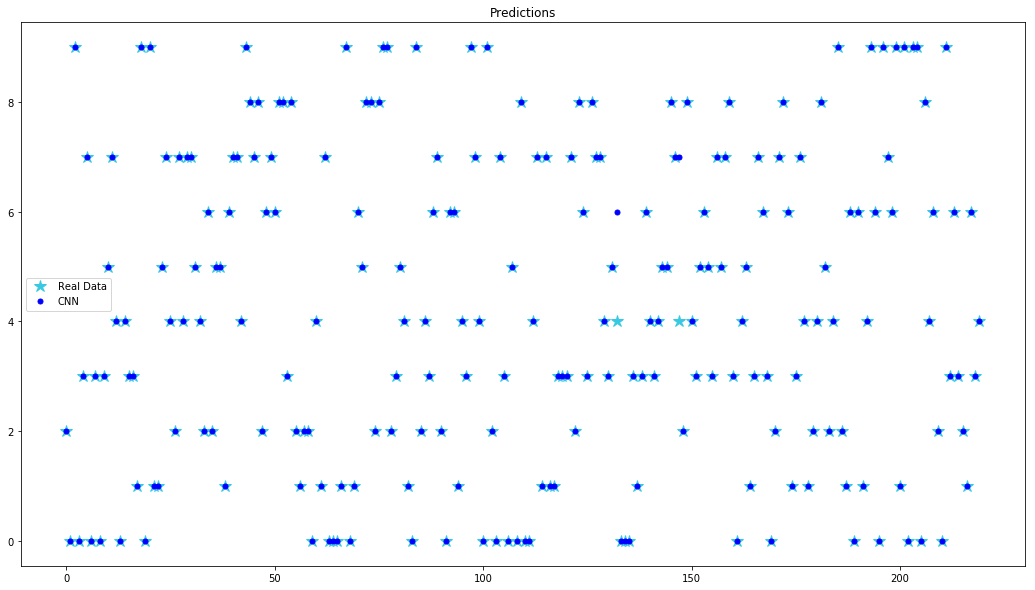

In [31]:
plt.figure(figsize = (18, 10))

plt.plot(real_data[0:220], '*', ms=12, c='#37c9e1', label='Real Data')

plt.plot(submission_cnn['Label'][0:220], 'bo', ms=5, label='CNN')
# plt.plot(submission_mlp['Label'][0:200], 'v', ms=5, label='MLP')
# plt.plot(submission_rnn['Label'][0:200], 's', ms=5, label='RNN')
# plt.plot(submission_mlpc['Label'][0:200], 'p', ms=5, label='MLPC')

plt.legend(loc=6)
plt.title("Predictions");

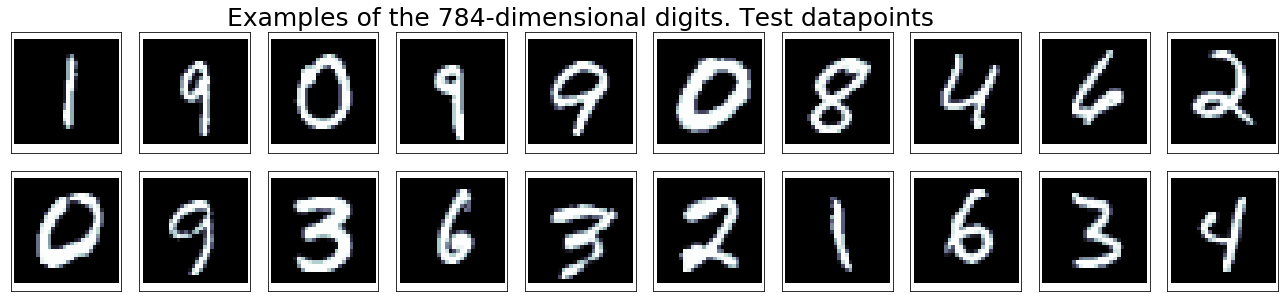

In [47]:
fig, ax = plt.subplots(figsize=(18, 4), nrows=2, ncols=10, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(20):
    image = test_images[200:220][i].reshape(28,28)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[4].set_title('Examples of the 784-dimensional digits. Test datapoints', fontsize=25);